# Notebook 1: Data Retrieval from FDB and Preprocessing

This notebook serves as a guide to accessing data from FDB (Fields Database) object storage and preprocessing. In the first part, it demonstrates the computation of median ensembles of precipitations aggregated over 6 hours, followed by a more complex computational process, the computation of potential vorticity.

https://github.com/MeteoSwiss/meteodata-lab

# Installation
To access the data from FDB, the kernel of the notebooks configures the necessary libraries and environmental variables. 
See instruction in [FDB installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation)


## Accessing Data from FDB

First we import few libraries:

In [1]:
from meteodatalab import mars, mch_model_data

We can use the fdb-utils in order to inspect the data that is present in the ICON-CH1-EPS and ICON-CH2-EPS collections. 
fdb-utils will return keys and values that can be used in the queries to FDB.

In [2]:
!fdb-utils list --filter number=0,step=0

/user-environment/venvs/fdb/lib/python3.11/site-packages/pyfdb/pyfdb.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
Keys/Values in FDB for {'number': '0', 'step': '0'}:
Invalid value depth=-2005530568 - setting depth=3
class: {'od'}
date: {'20250703', '20250704'}
expver: {'0001'}
model: {'icon-ch1-eps', 'icon-ch2-eps'}
number: {0}
stream: {'enfo'}
time: {'0900', '1200', '2100', '0300', '1800', '0000', '1500', '0600'}
type: {'ememb'}
levtype: {'ml', 'sfc', 'pl'}
param: {'503307', '500098', '500006', '503204', '500016', '500031', '500029', '500147', '503395', '500002', '500127', '500053', '500045', '500015', '500101', '503167', '503303', '500167', '500048', '500166', '500106', '500108', '500055', '500107', '500174', '500164', '500017', '500030', '5

The realtime data FDB only stores the latest forecast. Using fdb-utils you will find an ICON-CH1-EPS forecast reference time every 3 hours and ICON-CH2-EPS forecast reference time every 6 hours. We aim at retrieving the latest forecast started ~12 hours ago. 

In [3]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 3
rounded_hour = (past_time.hour // 3) * 3
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time

('20250704', '0900')

### Retrieving Data

Use query functions to retrieve the required data.

The request for data is made by specifying the values of MARS keys.
MARS keys are derived from GRIB keys and serve as a base for the FDB index.
The `meteodatalab.mars` module provides helpers to build valid MARS request in the context of MeteoSwiss.

Note that the available data in the test FDB instance is typically limited to the 2 last runs so make sure to update the date and time.

In [4]:
request = mars.Request(
    param="TOT_PREC",
    date=date,
    time=time,
    number=tuple(range(1)),
    step=tuple(str(i) for i in range(10)),  # minutes
    levtype=mars.LevType.SURFACE,
    model=mars.Model.ICON_CH1_EPS,
)

meteodatalab mars request fills some of the key:values required by FDB with defaults for ICON-CH1-EPS and ICON-CH2-EPS, and provides syntax verification of the request. You can inspect the raw FDB request:

In [5]:
request.to_fdb()

{'param': 500041,
 'date': '20250704',
 'time': '0900',
 'expver': '0001',
 'number': [0],
 'step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'class': 'od',
 'levtype': 'sfc',
 'model': 'ICON-CH1-EPS',
 'stream': 'enfo',
 'type': 'ememb'}

The `meteodatalab.mch_model_data` module provides some convenience functions to access model data.
Earthkit-data is used in the background to read the data that is being returned from FDB.

In [6]:
ds = mch_model_data.get_from_fdb(request)

/user-environment/venvs/fdb/lib/python3.11/site-packages/pyfdb/pyfdb.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


The data is returned as dictionary of xarray DataArrays where the keys are set to the param short name.

In [7]:
ds["TOT_PREC"]

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 10, y: 786, x: 1170)> Size: 37MB
array([[[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
...
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],

         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-07-04T09:00:00
  * lead_time   (lead_time) timedelta64[ns] 80B 00:00:00 01:00:00 ... 09:00:00
    lat         (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon         (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    valid_time  (ref_time, lead_time) datetime64[ns] 80B 2025-07-04T09:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

## Data Preprocessing for Computing Median Ensembles

We will compute the ensembles median of total precipitation aggregated over 6 hours:

### Data Aggregation
For aggregation of data over 6-hour intervals `meteodatalab` implements operators that transform the data. 

Total precipitation of the direct model output of ICON is accumulated from the reference time. We use the `delta` to reaggregate to 6 hour intervals.

In [8]:
import numpy as np
from meteodatalab.operators import time_operators as time_ops

In [9]:
tot_prec_6h = time_ops.delta(ds["TOT_PREC"], np.timedelta64(6, "h"))

In [10]:
tot_prec_6h

<xarray.DataArray (eps: 1, ref_time: 1, lead_time: 10, y: 786, x: 1170)> Size: 37MB
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 8B 0
  * ref_time    (ref_time) datetime64[ns] 8B 2025-07-04T09:00:00
  * lead_time   (lead_time) timedelta64[ns] 80B 00:00:00 01:00:00 ... 09:00:00
    lat         (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon         (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    valid_time  (ref_time, lead_time) datetime64[ns] 80B 2025-07-04T09:00:00 ...
Dimensions without coordinates: y, x
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500401, 'shortName': 'TOT_PRE...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

### Ensemble Calculation

Next we compute the ensembles median using the 6h aggregation:

In [11]:
data = tot_prec_6h.isel(lead_time=8).median(dim="eps").clip(min=0)

Finally we plot the results using earthkit-plots

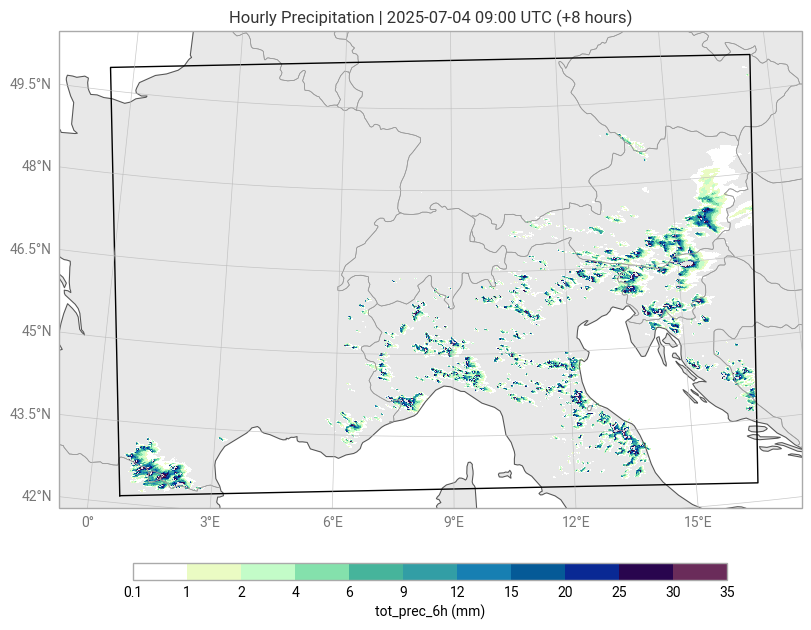

In [12]:
from earthkit.plots.geo import bounds, domains
from earthkit.plots.styles import Style
import earthkit
import cartopy.crs as ccrs
from plot_utils.load_colormaps import load_ncl_rgb_colors
from plot_utils.plot_valid_data_frame import get_valid_data_frame
import pandas as pd


# Define the spatial extent of the target grid
# (we retain the original ICON-CH1/CH2-EPS domain)
xmin, xmax = -0.757, 17.583   # Longitude bounds
ymin, ymax = 42.183, 50.583   # Latitude bounds

bbox = bounds.BoundingBox(xmin, xmax, ymin, ymax, ccrs.Geodetic())
domain = domains.Domain.from_bbox(
    bbox=bbox,
    name="CH2"
)
# === Load custom colormap with levels ===
colors, levels = load_ncl_rgb_colors("precip_1h_11lev")

chart = earthkit.plots.Map(domain=domain)
chart.grid_cells(data, x="lon", y="lat", style=Style(colors=colors, levels=levels))

# === Add Frame ===
frame_polygon = get_valid_data_frame(data)

if frame_polygon:
    x, y = frame_polygon.exterior.xy
    chart.ax.plot(x, y, color='black', linewidth=1, transform=ccrs.PlateCarree())
else:
    print("No valid frame polygon could be computed.")

# === Add Map Features ===
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

# === Annotate Chart ===
ref_time = pd.to_datetime(data.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = data.coords["lead_time"].values.astype('timedelta64[h]')

title = f"Hourly Precipitation | {ref_time} (+{lead_time})"
legend_label = f"tot_prec_6h ({'mm'})"

chart.title(title)
chart.legend(label=legend_label)
chart.show()


## Potential Vorticity Calculation and Wind Field Rotation

This notebook introduces another example that requires a multiple-field FDB request, in order to to compute the potential vorticity (PV) and rotating the wind field, representing a more intricate computational process compared to Notebook 1, which primarily focused on straightforward data retrieval and preprocessing.

### Querying Data

Utilize query functions to smoothly retrieve the nine required fields spanning all model levels.

In [14]:
request = mars.Request(
    param=("P", "T", "U", "V", "W", "QV", "QC", "QI"),
    date=date,
    time=time,
    number=0,
    step=7,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)

We also need the height field of the vertical levels. Since this is a constant field, it has some different key values than the previous fields (for example step). Therefore, we issue a separate request to obtain the constant HHL field:

In [15]:
request_hhl_const = mars.Request(
    param="HHL",
    date=date,
    time=time,
    number=0,
    step=0,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)

Issue the two requests and obtain the data:

In [16]:
ds = mch_model_data.get_from_fdb(request)

In [17]:
ds |= mch_model_data.get_from_fdb(request_hhl_const)

In [18]:
ds

{'P': <xarray.DataArray (eps: 1, ref_time: 1, lead_time: 1, z: 80, y: 786, x: 1170)> Size: 294MB
 array([[[[[[  5103.532 ,   5102.579 ,   5104.12  , ...,   5115.085 ,
               5114.964 ,   5114.9033],
            [  5103.5205,   5102.823 ,   5102.659 , ...,   5115.4736,
               5115.4365,   5115.2783],
            [  5102.7666,   5103.792 ,   5102.8857, ...,   5116.1006,
               5115.919 ,   5115.2725],
            ...,
            [  5115.003 ,   5115.0225,   5115.132 , ...,   5129.8447,
               5129.9307,   5130.7627],
            [  5115.04  ,   5115.1006,   5115.1826, ...,   5129.6533,
               5129.634 ,   5129.9756],
            [  5115.042 ,   5115.1533,   5115.21  , ...,   5129.7764,
               5129.536 ,   5128.8896]],
 
           [[  6693.7344,   6692.461 ,   6694.3203, ...,   6710.3633,
               6710.2773,   6710.254 ],
            [  6693.6367,   6692.699 ,   6692.3203, ...,   6710.793 ,
               6710.785 ,   6710.6562],
   

In [19]:
hhl = ds["HHL"].squeeze(drop=True)
hhl

<xarray.DataArray (z: 81, y: 786, x: 1170)> Size: 298MB
array([[[ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        ...,
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04]],

       [[ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
        [ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
        [ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
...
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          6.8602661e+02,  6.9027661e+02,  5.8840161e+02],
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          5.8952661e+02,  6.9215161e+02,  6.5052661e+02],
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          5.8990161e+02,  6.9602661e+02,  6.8340161e+02]],

       [[ 7.5947876e+02,  7.9360376e+02,  9.0522876e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        [ 8.8785376e+02,  9.3360376e+02,  9.3197876e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        [ 8.9010376e+02,  9.7310376e+02,  9.6222876e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        ...,
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          6.6610376e+02,  6.7022876e+02,  5.6847876e+02],
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          5.6947876e+02,  6.7210376e+02,  6.3047876e+02],
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          5.6997876e+02,  6.7597876e+02,  6.6347876e+02]]], dtype=float32)
Coordinates:
  * z        (z) int64 648B 1 2 3 4 5 6 7 8 9 10 ... 73 74 75 76 77 78 79 80 81
    lat      (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon      (y, x) float64 7MB 0.7593 0.7726 0.786 0.7993 ... 17.51 17.52 17.54
Dimensions without coordinates: y, x
Attributes:
    metadata:     <earthkit.data.readers.grib.metadata.StandAloneGribMetadata...
    parameter:    {'centre': 'lssw', 'paramId': 500008, 'shortName': 'HHL', '...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  model_level
    origin_z:     -0.5

### Computing Potential Vorticity

The next Jupyter cell will tackle the computation of potential vorticity, a more complex process that isn't directly computed by the model.

In [21]:
from meteodatalab import metadata
from meteodatalab.operators.rho import compute_rho_tot
from meteodatalab.operators.theta import compute_theta
from meteodatalab.operators.pot_vortic import compute_pot_vortic

In [22]:
theta = compute_theta(ds["P"], ds["T"])
rho_tot = compute_rho_tot(ds["T"], ds["P"], ds["QV"], ds["QC"], ds["QI"])

metadata.set_origin_xy(ds, "HHL")
pot_vortic = compute_pot_vortic(ds["U"], ds["V"], ds["W"], theta, rho_tot, hhl)

### Interpolate to potential temperature levels

It's possible to interpolate the potential vorticity on isotherms of potential temperature.

In [23]:
from meteodatalab.operators.destagger import destagger
from meteodatalab.operators.vertical_interpolation import interpolate_k2theta

In [24]:
# use mid-levels of hhl for the interpolation
hfl = destagger(hhl, "z")
theta_values = [310.0, 315.0, 320.0, 325.0, 330.0, 335.0]
pot_vortic_th = interpolate_k2theta(pot_vortic, "low_fold", theta, theta_values, "K", hfl)

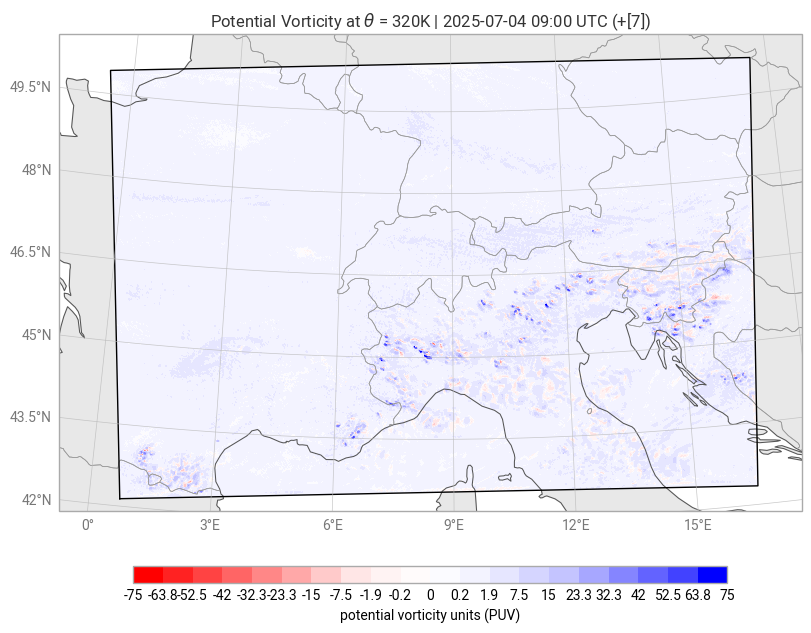

In [25]:
chart = earthkit.plots.Map(domain=domain)
# === Load custom colormap with levels ===
colors, levels = load_ncl_rgb_colors("pot_vortic")

chart.quickplot(pot_vortic_th.sel(z=320)*1e6, x="lon", y="lat", style=Style(colors=colors, levels=levels))

# === Add Frame ===
frame_polygon = get_valid_data_frame(data)

if frame_polygon:
    x, y = frame_polygon.exterior.xy
    chart.ax.plot(x, y, color='black', linewidth=1, transform=ccrs.PlateCarree())
else:
    print("No valid frame polygon could be computed.")

# === Add Map Features ===
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

ref_time = pd.to_datetime(pot_vortic_th.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = pot_vortic_th.coords["lead_time"].values.astype('timedelta64[h]')

title = f"Potential Vorticity at $\\theta$ = 320K | {ref_time} (+{lead_time})"
legend_label = f"potential vorticity units (PUV)"

chart.title(title)
chart.legend(label=legend_label)
chart.show()

### Compute the mean between pressure levels

There's also an option to compute the mean potential vorticity between two isobars (or pressure levels).

In [26]:
from meteodatalab.operators.vertical_interpolation import interpolate_k2p
from meteodatalab.operators.vertical_reduction import integrate_k

In [27]:
isobars = interpolate_k2p(hfl, "linear_in_lnp", ds["P"], [700, 900], "hPa")
h700, h900 = isobars.transpose("z", ...)
pot_vortic_mean = integrate_k(pot_vortic, "normed_integral", "z2z", hhl, (h900, h700))

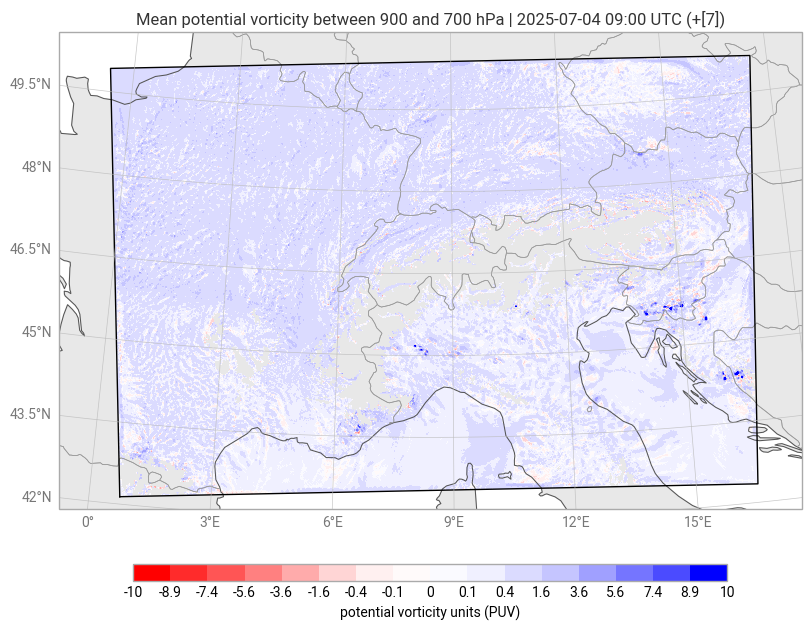

In [29]:
chart = earthkit.plots.Map(domain=domain)
# === Load custom colormap with levels ===
colors, _ = load_ncl_rgb_colors("pot_vortic")
levels = [-10.0,-8.9,-7.4,-5.6,-3.6,-1.6,-0.4,-0.1,0.0,0.1,0.4,1.6,3.6,5.6,7.4,8.9,10.0]
chart.quickplot(pot_vortic_mean*1e6, x="lon", y="lat", style=Style(colors=colors, levels=levels))

# === Add Frame ===
frame_polygon = get_valid_data_frame(data)

if frame_polygon:
    x, y = frame_polygon.exterior.xy
    chart.ax.plot(x, y, color='black', linewidth=1, transform=ccrs.PlateCarree())
else:
    print("No valid frame polygon could be computed.")

# === Add Map Features ===
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

ref_time = pd.to_datetime(pot_vortic_th.coords["ref_time"].values[0]).strftime("%Y-%m-%d %H:%M UTC")
lead_time = pot_vortic_th.coords["lead_time"].values.astype('timedelta64[h]')

title = f"Mean potential vorticity between 900 and 700 hPa | {ref_time} (+{lead_time})"
legend_label = f"potential vorticity units (PUV)"

chart.title(title)
chart.legend(label=legend_label)
chart.show()

## Summary

- retrieve data from FDB in python
- read GRIB data into xarray
- process the data with meteorological operators that are aware of the grib metadata
- keep the GRIB metadata consistent thoughout operations